# PS5

## Modeling of carbon cycle
In this problem, we will build a box model to understand the Earth’s carbon cycle based on the framework in [Tomizuka 2009](https://mathcs.holycross.edu/~little/Montserrat1112/envmodbackup/1%252E3013196-1.pdf).

### 1.1
Following equation 1-2 (without the buffer effect), build a two-box model to compute the atmospheric CO2 level in ppm (parts per million) from 1987 to 2004.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

parameters = {'axes.labelsize': 15,
              'axes.titlesize': 15}
plt.rcParams.update(parameters)

%matplotlib inline

In [2]:
# Import Global Co2 Emssions from Fossil-Fuel Burning data
fsl_CO2 = pd.read_csv('data_files/global.1751_2008.csv', skiprows = [1], usecols = [0,1])
fsl_CO2 = fsl_CO2.loc[(fsl_CO2['Year"'] > 1985) & (fsl_CO2['Year"'] < 2005)].reset_index(drop=True)
# Convert the values into ppm
fsl_CO2 = fsl_CO2.iloc[:,1]/1000/2.13
fsl_CO2.head()

0    2.633333
1    2.701878
2    2.801878
3    2.858216
4    2.887793
Name: Total carbon emissions from fossil-fuels (million metric tons of C), dtype: float64

Text(0, 0.5, '$\\gamma$')

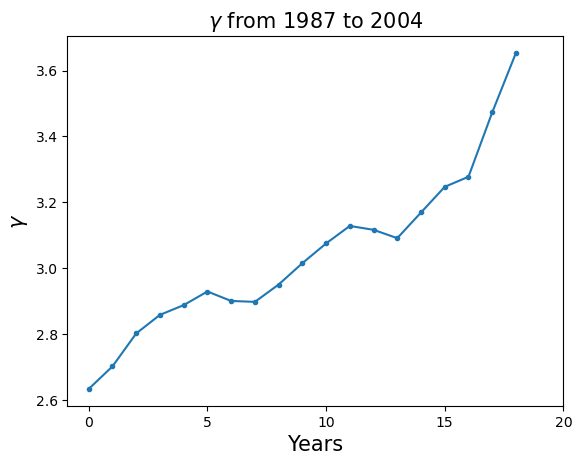

In [3]:
# One tricky problem is that the gamma varies every year,
# so we have to figure out a method to update the gamma
# every step we take
plt.plot(fsl_CO2, marker = '.')
plt.title(r'$\gamma$ from 1987 to 2004')
plt.xticks([0,5,10,15,20])
plt.xlabel('Years')
plt.ylabel(r'$\gamma$')

In [4]:
def twoBoxmodel(w, t, p):
    """
    Defines the differential equations for the two-box system model.
    
    Arguments:
        w: vector ofthe sate variables:
            w = [N_1, N_2]
        t: time
        p: vector of the parameters:
            p = [k_12, k_21, g]
    """
    N_1, N_2 = w
    k_12, k_21, g = p
    
    g = fsl_CO2[int(t)]
    
    # Create f = (N_1, N_2):
    f = [-k_12*N_1 + k_21*N_2 + g,
         k_12*N_1-k_21*N_2]
    return f

In [5]:
from scipy.integrate import odeint

# Parameter values
k_12 = 105/740
k_21 = 102/900
g = fsl_CO2[0]

# Initial conditions
N_1 = 740/2.13
N_2 = 900/2.13

# Set the time
t = np.arange(0,2004-1986+1)

# Pack up the parameters and initial conditions:
p = [k_12, k_21, g]
w0 = [N_1, N_2]

# Call the ODE solver.
wsol = odeint(twoBoxmodel, w0, t, args=(p,))
atm_sol = wsol[:,0]
soc_sol = wsol[:,0]

In [6]:
# Print the solution
year = np.arange(1986,2005,1)
sol_1 = pd.DataFrame({'Year':year,
                      'Atmos CO2 level (ppm)':atm_sol})
sol_1

,Year,Atmos CO2 level (ppm)
0,1986,347.417840
1,1987,348.636202
2,1988,349.907589
3,1989,351.256315
4,1990,352.634155
5,1991,354.015176
6,1992,355.412573
7,1993,356.761422
8,1994,358.093931
9,1995,359.465249


In [7]:
# Import Mauna Lao Volcano Observed values
obsv_CO2 = pd.read_csv('data_files/co2_annmean_mlo.csv',usecols = [0,1], comment = '#')
obsv_CO2 = obsv_CO2.loc[(obsv_CO2['year'] > 1985) & (obsv_CO2['year'] < 2005)].reset_index(drop=True)
obsv_CO2.head()

,year,mean
0,1986,347.61
1,1987,349.31
2,1988,351.69
3,1989,353.20
4,1990,354.45


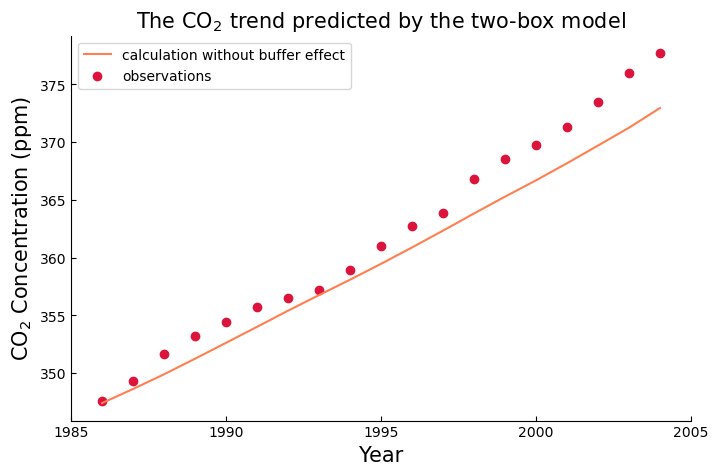

In [8]:
# Plot the solution and observation values
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(year,atm_sol,c = 'coral')
ax.scatter(year,obsv_CO2['mean'],c = 'crimson')
ax.set(title = r'The CO$_2$ trend predicted by the two-box model',
       xlabel = 'Year', ylabel = r'CO$_2$ Concentration (ppm)',
       xticks = np.arange(1985,2010,5))
ax.legend(['calculation without buffer effect','observations'])
ax.spines['top'].set_visible(None)
ax.spines['right'].set_visible(None)
ax.tick_params('both',which = 'major', direction = 'in')
plt.show()

### 1.2
Following equation 3-4 (with the buffer effect), build a two-box model to compute the atmospheric CO2 level in ppm from 1987 to 2004.

In [9]:
def xi(N_1):
    xi = 3.69+1.86*(1e-2)*N_1-1.8*(1e-6)*N_1*N_1
    return xi

In [10]:
def twoBoxmodel_buffer(w, t, p):
    """
    Defines the differential equations for the two-box system model.
    
    Arguments:
        w: vector ofthe sate variables:
            w = [N_1, N_2]
        t: time
        p: vector of the parameters:
            p = [k_12, k_21, N_20, g, xi]
    """
    N_1, N_2 = w
    k_12, k_21, N_20, g, x = p
    
    g = fsl_CO2[int(t)]
    x = xi(N_1)
    
    # Create f = (N_1, N_2):
    f = [-k_12*N_1 + k_21*(N_20+x*(N_2-N_20)) + g,
         k_12*N_1-k_21*(N_20+x*(N_2-N_20))]
    return f

In [11]:
# Parameter values
k_12 = 105/740
k_21 = 102/900
N_20 = 821/2.13
g = fsl_CO2[0]

# Initial conditions
N_1 = 740/2.13
N_2 = 900/2.13
x = xi(N_1)

# Set the time
t = np.arange(0,2004-1986+1)

# Pack up the parameters and initial conditions:
p = [k_12, k_21, N_20, g, x]
w0 = [N_1, N_2]

# Call the ODE solver.
wsol_buffer = odeint(twoBoxmodel_buffer, w0, t, args=(p,))

In [12]:
atm_sol_buffer = wsol_buffer[:,0]
soc_sol_buffer = wsol_buffer[:,0]

In [13]:
# Print the solution
sol_2 = pd.DataFrame({'Year':year,
                      'Atmos CO2 level (ppm)':atm_sol_buffer})
sol_2

,Year,Atmos CO2 level (ppm)
0,1986,347.417840
1,1987,370.778493
2,1988,379.125990
3,1989,383.271379
4,1990,386.294622
5,1991,389.029031
6,1992,391.718680
7,1993,394.358466
8,1994,396.992236
9,1995,399.677076


### 1.3
Based on your results from 1.1 and 1.2, reproduce Figure 2 in Tomizuka (2009) as much as you can.

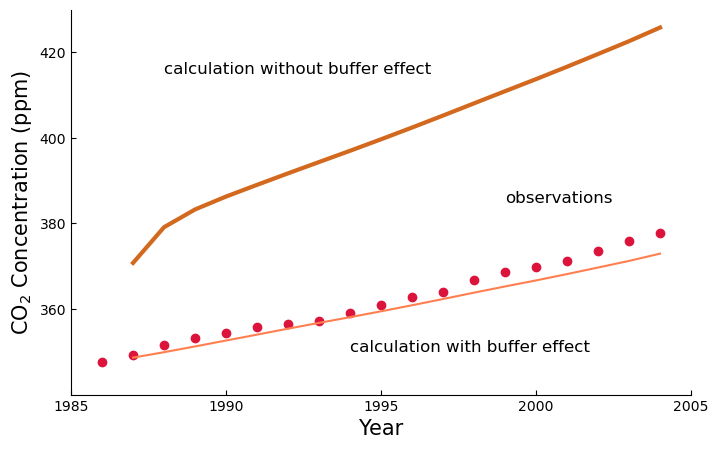

In [14]:
# Plot the solution and observation values
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(year[1:],atm_sol[1:],c = 'coral')
ax.plot(year[1:],atm_sol_buffer[1:], linewidth = 3, c = 'chocolate')
ax.scatter(year,obsv_CO2['mean'],c = 'crimson')
ax.set(xlabel = 'Year', ylabel = r'CO$_2$ Concentration (ppm)',
       xticks = np.arange(1985,2010,5),
       ylim = (340,430),
       yticks = np.arange(360,440,20))
ax.spines['top'].set_visible(None)
ax.spines['right'].set_visible(None)
ax.tick_params('both',which = 'major', direction = 'in')
ax.annotate('calculation without buffer effect',(1988,415), fontsize = 12)
ax.annotate('calculation with buffer effect',(1994,350), fontsize = 12)
ax.annotate('observations',(1999,385), fontsize = 12)
plt.show()